In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# Parameters
# -----------------------------
INPUT_DIR = "D:/dataset/mult_mha_to_npz"
OUTPUT_DIR = "D:/dataset/npz_80"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_FRAMES = 80  # total frames to save per case
# -----------------------------
# Step 1: Convert dataset
# -----------------------------
print("Building reduced dataset...")

for file in tqdm(sorted(os.listdir(INPUT_DIR))):
    if not file.endswith(".npz"):
        continue

    path = os.path.join(INPUT_DIR, file)
    case = np.load(path)

    images = case["image"]
    masks = case["mask"]
    labels = case["label"]
    pixel_spacing = case["pixel_spacing"]
    ac_reference = case["ac_reference"]
    uuid = case["uuid"]

    # -----------------------------
    # Separate positive and negative frames
    # -----------------------------
    pos_idx = np.where(labels > 0)[0]
    neg_idx = np.where(labels == 0)[0]

    rng = np.random.default_rng(seed=42)
    rng.shuffle(pos_idx)
    rng.shuffle(neg_idx)

    # Keep ALL positives
    n_pos = len(pos_idx)

    # Remaining slots for negatives
    n_neg = TARGET_FRAMES - n_pos
    if n_neg < 0:
        # Too many positives → just keep first 80
        chosen_idx = pos_idx[:TARGET_FRAMES]
    else:
        # Take negatives (pad if needed)
        if len(neg_idx) < n_neg:
            extra_neg = rng.choice(neg_idx, size=n_neg - len(neg_idx), replace=True)
            neg_idx = np.concatenate([neg_idx, extra_neg])
        chosen_idx = np.concatenate([pos_idx, neg_idx[:n_neg]])

    rng.shuffle(chosen_idx)

    # Extract frames
    images_new = images[chosen_idx]
    masks_new = masks[chosen_idx]
    labels_new = labels[chosen_idx]

    # -----------------------------
    # Save reduced npz
    # -----------------------------
    out_path = os.path.join(OUTPUT_DIR, file)
    np.savez_compressed(
        out_path,
        image=images_new,
        mask=masks_new,
        label=labels_new,
        pixel_spacing=pixel_spacing,
        ac_reference=ac_reference,
        uuid=uuid,
    )

    print(f"{file}: saved {len(chosen_idx)} frames "
          f"({np.sum(labels_new > 0)} positives, {np.sum(labels_new == 0)} negatives)")



Found 1 optimal, 2 suboptimal frames


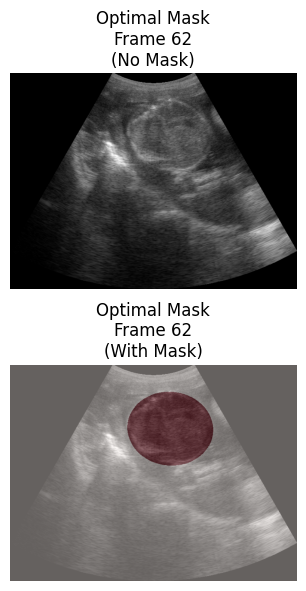

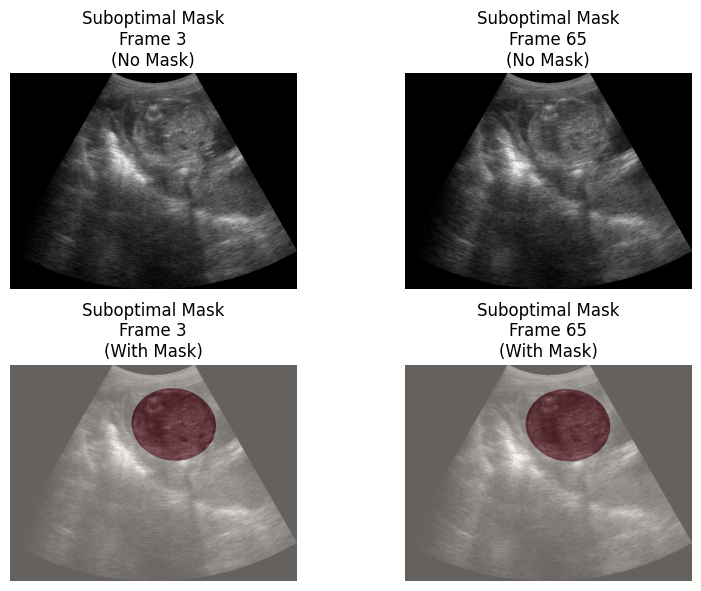

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load one reduced case
# -----------------------------
CASE_PATH = "D:/dataset/npz_80/1b250c39-7217-4921-838b-ed2681ebfef2.npz"  # change to any file
case = np.load(CASE_PATH)

images = case["image"]
masks = case["mask"]

# -----------------------------
# Categorize frames by mask area
# -----------------------------
mask_areas = masks.reshape(masks.shape[0], -1).sum(axis=1)

# Optimal mask = top 5% largest areas
threshold_optimal = np.percentile(mask_areas[mask_areas > 0], 95) if (mask_areas > 0).any() else 0
optimal_idx = np.where(mask_areas >= threshold_optimal)[0]

# Suboptimal mask = bottom 25% of non-empty masks
threshold_subopt = np.percentile(mask_areas[mask_areas > 0], 25) if (mask_areas > 0).any() else 0
subopt_idx = np.where((mask_areas > 0) & (mask_areas <= threshold_subopt))[0]

print(f"Found {len(optimal_idx)} optimal, {len(subopt_idx)} suboptimal frames")

# -----------------------------
# Plot function: side-by-side (no mask vs with mask)
# -----------------------------
def show_side_by_side(indices, title, n=3):
    if len(indices) == 0:
        print(f"No {title} frames found")
        return
    
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices[:n]):
        # Image only
        plt.subplot(2, n, i+1)
        plt.imshow(images[idx], cmap="gray")
        plt.title(f"{title}\nFrame {idx}\n(No Mask)")
        plt.axis("off")
        
        # Image with mask
        plt.subplot(2, n, n+i+1)
        plt.imshow(images[idx], cmap="gray")
        plt.imshow(masks[idx], cmap="Reds", alpha=0.4)
        plt.title(f"{title}\nFrame {idx}\n(With Mask)")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# -----------------------------
# Visualize
# -----------------------------
show_side_by_side(optimal_idx, "Optimal Mask")
show_side_by_side(subopt_idx, "Suboptimal Mask")
